# Creates plots for multiple steps

In [27]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import json

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

tf.random.set_random_seed(13)

import py3nvml
py3nvml.grab_gpus(1)

1

In [28]:
# lat: 35.7695, lng: -117.5993333, mag: 7.1, idx: 2126

EARTHQUAKE_IDX = 2175

In [29]:
quake_data = None
with open('../data/acc/compressed/event_metadata.json') as f:
    meta = json.load(f)
    quake_data = meta[EARTHQUAKE_IDX]
    
print(quake_data)

{'mag': 3.3, 'mag_type': 'Ml', 'lat': 35.758, 'lng': -117.5613333, 'depth': 7.57, 'x': 49.222291234489305, 'y': 61.49079443444147, 'z': 7.57, 'date': '2019-07-06'}


In [30]:
dataset = np.load('../data/acc/compressed/full_data.npy')
print("Before: ", dataset.shape)
#Swap axes
dataset = dataset.swapaxes(1, -1)

#Combine station and xyz
#dataset = dataset.reshape(dataset.shape[0], dataset.shape[1], -1)
print("After: ", dataset.shape)

Before:  (35679, 15, 60)
After:  (35679, 60, 15)


In [31]:
data_mean = np.mean(dataset, axis = 1)
data_var = np.linalg.norm(dataset - np.expand_dims(data_mean, 1), axis = 1)

#Add some epsilon to make the divide by zero var work
epsilon = 1
data_var[data_var == 0] = epsilon
data_var[data_var == 0] = epsilon

dataset = (dataset - np.expand_dims(data_mean, 1))/np.expand_dims(data_var, 1)

# Extract a quake

In [32]:
#Get a single quake
quake = dataset[EARTHQUAKE_IDX]
quake = quake.reshape((1, *quake.shape))
quake.shape

(1, 60, 15)

In [33]:
def multivariate_data(dataset, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []
    
    start_index = history_size
    end_index = dataset.shape[1] - target_size
        
    for quake in dataset:

        for i in range(start_index, end_index):
            indices = range(i-history_size, i, step)
            data.append(quake[indices])

            if single_step:
                labels.append(quake[i+target_size])
            else:
                labels.append(quake[i:i+target_size])

    return np.array(data), np.array(labels)

In [34]:
past_history = 15
future_target = 10
STEP = 1

x_train_multi, y_train_multi = multivariate_data(quake, past_history, future_target, STEP)

print(x_train_multi.shape, y_train_multi.shape)

(35, 15, 15) (35, 10, 15)


# Load the model

In [35]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(128,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(64, return_sequences=True, activation='relu'))
multi_step_model.add(tf.keras.layers.LSTM(64, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(150))

multi_step_model.load_weights("trained_models_acc/multistep/LSTM3_10steps.h5")

multi_step_model.compile(optimizer='adam', loss='mae', metrics= ['mse', 'mae'])
multi_step_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 15, 128)           73728     
_________________________________________________________________
lstm_4 (LSTM)                (None, 15, 64)            49408     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 150)               9750      
Total params: 165,910
Trainable params: 165,910
Non-trainable params: 0
_________________________________________________________________


In [36]:
y_pred = multi_step_model.predict(x_train_multi)
y_pred = y_pred.reshape((y_pred.shape[0], 10, -1))
y_train_multi = y_train_multi.reshape((y_pred.shape[0], 10, -1))
y_pred.shape, y_train_multi.shape

((35, 10, 15), (35, 10, 15))

In [37]:
# def accumulate(y):
#     avg_pred = np.zeros((y.shape[0] + y.shape[1] - 1, 15))
#     for i, pred in enumerate(y):
#         avg_pred[i:i+5] += pred
#     for i in range(len(avg_pred)):
#         denom = min(5, i + 1, len(avg_pred) - i + 1)
#         avg_pred[i] = avg_pred[i]/denom
        
#     return avg_pred

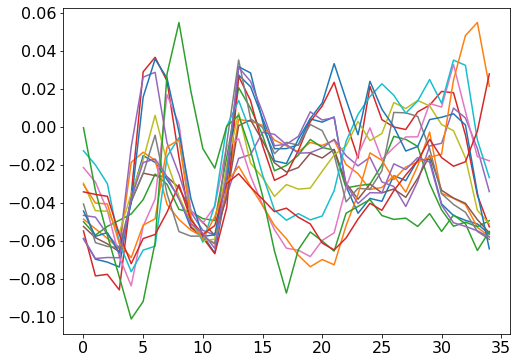

In [38]:
plt.plot(y_pred[:, -1, :])

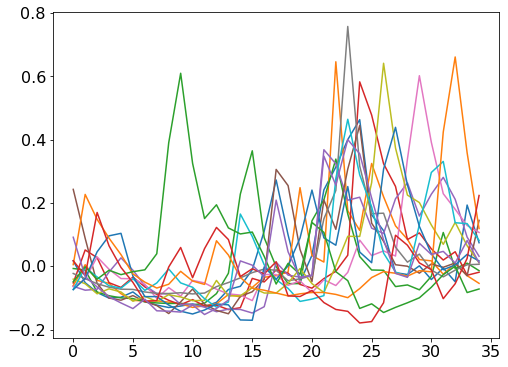

In [39]:
plt.plot(y_train_multi[:, -1, :])

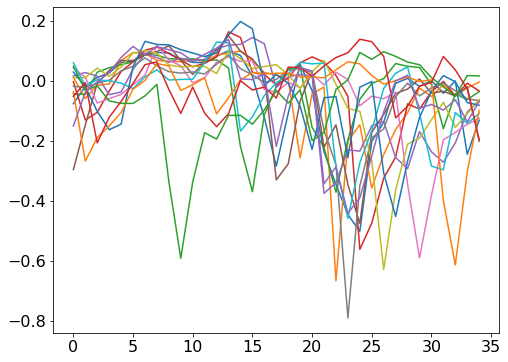

In [40]:
plt.plot(y_pred[:, -1, :] - y_train_multi[:, -1, :])

In [41]:
import sys
from os.path import dirname
sys.path.append(dirname("../"))

import numpy as np
import json

from utils.make_timeplot import multi_step_plot

In [42]:
dataset = np.load('../data/acc/compressed/full_data.npy')
metadata = None
with open('../data/acc/compressed/event_metadata.json','r') as fd:
    metadata = json.load(fd)

for i in range(y_pred.shape[1]):
    history = quake[0, :15 + i].swapaxes(0, 1)
    true_future = quake[0, 15 + i:].swapaxes(0, 1)
    epicenter = (metadata[EARTHQUAKE_IDX]['lat'], metadata[EARTHQUAKE_IDX]['lng'])
    pred = y_pred[:, i, :].swapaxes(0, 1)
    multi_step_plot(
        history, 
        true_future, 
        f"./multi_station_plots/tmp/{i + 1}_second_pred.png", 
        quake_data,
        prediction = pred, 
        scale = 0.3, 
        title = f"Combined {i + 1} second projections"
    )

100%|██████████| 15/15 [00:00<00:00, 176.22it/s]


(35, 10, 15)


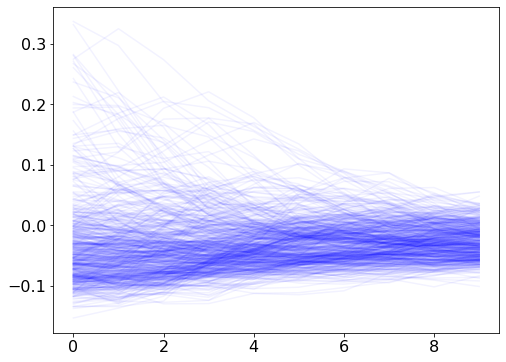

In [43]:
print(y_pred.shape)

for data in y_pred:
    plt.plot(data, alpha=0.05, color='blue')

In [44]:
from pathlib import Path
import imageio

images = []
for filename in sorted(Path('./multi_station_plots/tmp').glob("*_second_pred.png"), key=lambda i: int(os.path.splitext(os.path.basename(i))[0][0])):
    images.append(imageio.imread(filename))
    
with imageio.get_writer('./multi_station_plots/multi_timestep.gif', mode='I') as writer:
    for image in images:
        writer.append_data(image)

In [45]:
for i in range(y_pred.shape[0]):
    history = quake[0, :15 + i].swapaxes(0, 1)
    true_future = quake[0, 15 + i:].swapaxes(0, 1)
    epicenter = (metadata[EARTHQUAKE_IDX]['lat'], metadata[EARTHQUAKE_IDX]['lng'])
    pred = y_pred[i, :, :].swapaxes(0, 1)
    multi_step_plot(
        history, 
        true_future, 
        f"./multi_station_plots/tmp/{i + 1}_window_pred.png", 
        quake_data,
        prediction = pred, 
        scale = 0.3, 
        title = f"10 second wide window {i} seconds after initial wave detection"
    )

100%|██████████| 15/15 [00:00<00:00, 172.04it/s]


In [46]:
images = []
filenames = sorted(
    Path('./multi_station_plots/tmp').glob("*_window_pred.png"), 
    key=lambda i: int(os.path.splitext(os.path.basename(i))[0][0:os.path.splitext(os.path.basename(i))[0].find('_')])
)

for filename in filenames:
    images.append(imageio.imread(filename))
    
with imageio.get_writer('./multi_station_plots/multi_timestep_preds.gif', mode='I') as writer:
    for image in images:
        writer.append_data(image)

In [47]:
from utils.make_gif import generate_gifs

tenth_second_preds = np.zeros(quake.shape)
for i in range(y_pred.shape[0]):
    tenth_second_preds[:, 15 + 10 + i] = np.abs(y_pred[i, 9])
    
generate_gifs(
        np.abs(quake)[0],
        './gifs',
        'tenth_second_gif.gif',
        '../utils/ridgecrest.png',
        predicted_intensities = tenth_second_preds[0],
        scale = 1000,
    )

  0%|          | 0/60 [00:00<?, ?it/s]

Generating plots for each timestep...


  3%|▎         | 2/60 [00:00<00:03, 18.58it/s]

Combining plots to generate gif...


100%|██████████| 60/60 [00:02<00:00, 20.15it/s]


./gifs/tenth_second_gif.gif
Clearing temp files...
Gif stored at: ./gifs/tenth_second_gif.gif


'./gifs/tenth_second_gif.gif'